<a href="https://colab.research.google.com/github/daibiaoxuwu/colab_code/blob/master/with_basic_preprocessing_7x7_usealldata_0306_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 以相似度为训练目标
这是第二版
上次的结果是with_basic_preprocessing_7x7_usedata3_0303_2
checkpoint_path = "drive/MyDrive/drive/MyDrive/model_0303_7x7/cp.ckpt"
保存在这里，但是似乎最后不知道为什么，loss全变成NAN

下面打算使用8层，0~7，在01“2”34“5”67中第2和5层upsample试一下



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r 1
!mkdir 1
!unzip -q -o drive/MyDrive/train_data/20210219after/01cut.zip -d 1
!unzip -q -o drive/MyDrive/train_data/20210219after/01time.zip -d 1
!ls 1
!mv 1/01time 1/ans
!mv 1/01c 1/input
!ls 1

!rm -r 2
!mkdir 2
!unzip -q -o drive/MyDrive/train_data/20210218morni/02cut2.zip -d 2
!unzip -q -o drive/MyDrive/train_data/20210218morni/02time.zip -d 2
!ls 2
!mv 2/0 2/ans
!mv 2/02tt 2/input
!ls 2


!rm -r 3
!mkdir 3
!unzip -q -o drive/MyDrive/train_data/3/03cut.zip -d 3
!unzip -q -o drive/MyDrive/train_data/3/1613884.zip -d 3
!ls 3
!mv 3/0 3/ans
!mv 3/03cut 3/input
!ls 3

!rm -r 4
!mkdir 4
!unzip -q -o drive/MyDrive/train_data/4/04cut.zip -d 4
!unzip -q -o drive/MyDrive/train_data/4/0.zip -d 4
!ls 4 
!mv 4/0 4/ans
!mv 4/04cut 4/input
!ls 4


rm: cannot remove '1': No such file or directory
01c  01time
ans  input
rm: cannot remove '2': No such file or directory
0  02tt
ans  input
rm: cannot remove '3': No such file or directory
0  03cut
ans  input
rm: cannot remove '4': No such file or directory
0  04cut
ans  input


## 这里把ans改成灰度图读入了

# 1


In [ ]:

#lowpercent = 125.0
#highpercent = 233.0
def read_data(path1, path2):
    import tracemalloc
    tracemalloc.start(5)  # save upto 5 stack frames
    time1 = tracemalloc.take_snapshot()

    clip_x1_r = 34/119 #38  # 54 - 38=16, bmp 图像的竖直方向，高度方向进行裁剪----从输入的大图中，取出其中的6个汉字
    clip_x2_r = 85/119
    clip_y1_r = 26/201 #15  # 84-15 =69 bmp 图像的水平方向，宽度方向进行裁剪
    clip_y2_r = 126/201

    common_shape_x = -1
    common_shape_y = -1


    dat_size_x = 7
    dat_size_y = 7
    pic_num = 10  # 20

    enhance = 4
    debugflag = 5
    import os
    import cv2
    import numpy as np
    import random
    from matplotlib import pyplot as plt  
    import imutils
    debugflag = 5
    x_train0 = []  # 很多图，1万张以上，组成的数组
    y_train0 = dict()  # 总共100张图左右，很小,左边是时间，  右边是图
    idxes = dict()  # 左边是：y_train0中的图对应的时间；  右边是：x_train0数字索引组成的数组

    #参考图片
    for filename in os.listdir(path2):
      if 'git' in filename: continue
      ans = cv2.imread(os.path.join(path2,filename),cv2.IMREAD_GRAYSCALE)
      if ans is None:
        print(filename)
        continue
      ans = ans.astype('float32')   
      ans = ans[240:1812,:]
      ans = imutils.rotate_bound(ans, 270)
      #ans = ans / 255.0
      #去除颜色影响 直接变成0和1
      #ans = np.clip((ans - lowpercent)/(highpercent - lowpercent),0,1)
      clip_x1 = int(clip_x1_r * ans.shape[0])
      clip_x2 = int(clip_x2_r * ans.shape[0])
      clip_y1 = int(clip_y1_r * ans.shape[1])
      clip_y2 = int(clip_y2_r * ans.shape[1])
      ans = ans[clip_x1:clip_x2, clip_y1:clip_y2]

      y_train0[int(filename.split('_')[0])]=ans.astype(np.uint8)
      
    keys = list(y_train0.keys())

    # read data
    # add an axis and /255
    filelist = os.listdir(path1)
    #filelist = filelist[:7000]#int(len(filelist)/5)]
    random.shuffle(filelist)  # 所有元素随机排序
    index = 0
    for filename in filelist:
        if 'git' in filename or 'c.jpg' in filename or '1613702965215' in filename:
            continue
        ftime = int(filename.split('_')[0])

        value = max(filter(lambda t: t < ftime, keys))  # 比它ftime小，  小里面最大的那个
        if abs(ftime - value) < 2000:  # 如果时间差超过10s，则扔掉。
          continue

        a1 = cv2.imread(os.path.join(path1, filename)).astype('float32')   
        if common_shape_x == -1:
          common_shape_x = a1.shape[0]
          common_shape_y = a1.shape[1]
        elif abs(common_shape_x - a1.shape[0]) > 5 or abs(common_shape_y - a1.shape[1]) > 5:
          print(filename,a1.shape)
          continue


        a1 = a1[1:-1,1:-1]
        clip_x1 = int(clip_x1_r * a1.shape[0])
        clip_x2 = int(clip_x2_r * a1.shape[0])
        clip_y1 = int(clip_y1_r * a1.shape[1])
        clip_y2 = int(clip_y2_r * a1.shape[1])

        a2 = a1[clip_x1:clip_x2, clip_y1:clip_y2, :].astype('float32')

        image_channels = []
        for channel_id in range(3):
            image_channel = a2[:, :, channel_id]


            #image_channel[image_channel > 92] = 92
            try:
              image_channel -= np.min(image_channel)
              image_channel *= (255/np.max(image_channel))
              image_channel = 1 - image_channel

              image_channels.append(image_channel)  
            except Exception as e:
              print(image_channel.shape)
              print(a2.shape)
              print(a1.shape)
              print(filename)
              raise e 
        a3 = np.stack(image_channels,axis=2).astype(np.uint8)
        
        
        x_train0.append(a3)  # 裁剪 归一化 0-1.0之间浮点数
        if value not in idxes:
            idxes[value] = [index]
        else:
            idxes[value].append(index)
        index += 1

    # index data
    print(len(x_train0), index, len(y_train0), len(idxes.keys()))
    lens = [len(i) for i in idxes.values()]
    print(min(lens), max(lens), np.average(lens))
    for key, val in list(idxes.items()):
        if len(val) < pic_num:
            idxes.pop(key)

    def data_generator(ikeys_t,picflag):  # generator
        debugflag = 5
        while True:
            dataout = []
            key = random.choice(ikeys_t)
            idx2 = random.sample(idxes[key], pic_num)
            posx = random.randint(0, clip_x2 - clip_x1 - dat_size_x - 5)
            posy = random.randint(0, clip_y2 - clip_y1 - dat_size_y - 5)

            for i in range(pic_num):
              if picflag:
                dataout.append(x_train0[idx2[i]])
              else:
                dataout.append(x_train0[idx2[i]][posx:posx + dat_size_x, posy:posy + dat_size_y, :])
                assert(dataout[-1].shape[0] == dat_size_x)
                assert(dataout[-1].shape[1] == dat_size_y)


            ans_resize = cv2.resize(y_train0[key],(x_train0[idx2[i]].shape[1]*enhance,x_train0[idx2[i]].shape[0]*enhance))
            
            #debug
            if False:#debugflag > 0:   
              debugflag -= 1 
              temp = cv2.resize(y_train0[key],(x_train0[idx2[i]].shape[1],x_train0[idx2[i]].shape[0]))
              temp = cv2.GaussianBlur(temp,(7,7),0)
              image_channels = []
              for channel_id in range(3):
                  image_channel = temp[:, :, channel_id]


                  #image_channel[image_channel > 92] = 92
                  try:
                    image_channel -= np.min(image_channel)
                    image_channel *= (1/np.max(image_channel))
                    image_channel = 1 - image_channel

                    image_channels.append(image_channel)  
                  except Exception as e:
                    print(image_channel.shape)
                    raise e 
              temp = np.stack(image_channels,axis=2)
                      
              
              plt.imshow(x_train0[idx2[0]])
              plt.show()              
              plt.imshow(temp)
              plt.show()
              plt.imshow(ans_resize)
              plt.show()
            if picflag:
              ansout = ans_resize
            else:
              ansout=ans_resize[posx * enhance:(posx + dat_size_x) * enhance, posy * enhance:(posy + dat_size_y) * enhance]
              assert(ansout.shape[0] == dat_size_x * enhance)
              assert(ansout.shape[1] == dat_size_y * enhance)

            if False:#debugflag > 0:
              plt.imshow(dataout[0])
              plt.show()
              plt.imshow(temp[posx:posx + dat_size_x, posy:posy + dat_size_y, :])
              plt.show()
              plt.imshow(ansout)
              plt.show()
            yield dataout, ansout
    '''
    def pic_generator(ikeys_t):
        while True:
            key = random.choice(ikeys_t)
            idx2 = random.sample(idxes[key], pic_num)
            data = [x_train0[i] for i in idx2]
            ans = y_train0[key]
            yield data, ans'''

    ikeys = list(idxes.keys())  # split
    random.shuffle(ikeys)
    ltrain = int(len(ikeys) * 0.8)
    train_generator = data_generator(ikeys[:ltrain],picflag=False)
    test_generator = data_generator(ikeys[ltrain:],picflag=False)
    train_pic_generator = data_generator(ikeys[:ltrain],picflag=True)
    test_pic_generator = data_generator(ikeys[ltrain:],picflag=True)

    time2 = tracemalloc.take_snapshot()
    stats = time2.compare_to(time1, 'lineno')
    for stat in stats[:3]:
      print(stat)
    return train_generator, test_generator, train_pic_generator, test_pic_generator



train_generators = [0, 0, 0, 0, 0, 0, 0]
test_generators = [0, 0, 0, 0, 0, 0, 0]
train_pic_generators = [0, 0, 0, 0, 0, 0, 0]
test_pic_generators = [0, 0, 0, 0, 0, 0, 0]
train_generators[0], test_generators[0], train_pic_generators[0], test_pic_generators[0] = read_data('1/input','1/ans')
import gc
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)


train_generators[1], test_generators[1], train_pic_generators[1], test_pic_generators[1] = read_data('2/input','2/ans')
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)
'''
for i in list(globals().keys()):
    if(i[0] != '_' and 'generat' not in i and 'read_data' not in i):
        print(i)
        exec('del {}'.format(i))
'''        
train_generators[2], test_generators[2], train_pic_generators[2], test_pic_generators[2] = read_data('3/input','3/ans')
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)
train_generators[3], test_generators[3], train_pic_generators[3], test_pic_generators[3] = read_data('4/input','4/ans')
n = gc.collect()
print("Number of unreachable objects collected by GC:", n)

clip_x1_r = 34/119 #38  # 54 - 38=16, bmp 图像的竖直方向，高度方向进行裁剪----从输入的大图中，取出其中的6个汉字
clip_x2_r = 85/119
clip_y1_r = 26/201 #15  # 84-15 =69 bmp 图像的水平方向，宽度方向进行裁剪
clip_y2_r = 126/201


dat_size_x = 7
dat_size_y = 7
pic_num = 10  # 20

enhance = 4
debugflag = 5
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt  
import imutils

1613703573897_24190per39.jpg (19, 20, 3)
1613703724852_27626per32.jpg (21, 18, 3)
1613702613811_2238per53.jpg (93, 87, 3)
1613703598484_24733per40.jpg (96, 96, 3)
1613703629024_25433per30.jpg (19, 16, 3)
1613703608239_24950per32.jpg (18, 25, 3)
1613702824572_7063per40.jpg (83, 77, 3)
1613702963571_10241per41.jpg (173, 123, 3)
1613702757129_5510per48.jpg (133, 18, 3)
1613703757831_28376per30.jpg (21, 25, 3)
1613702726063_4807per45.jpg (134, 18, 3)
1613702901043_8814per42.jpg (124, 9, 3)
1613703146985_14423per2.jpg (22, 25, 3)
1613703050560_12214per46.jpg (198, 191, 3)
1613703058275_12389per47.jpg (91, 85, 3)
1613703743961_28057per32.jpg (57, 47, 3)
1613703755551_28328per36.jpg (56, 46, 3)
1613703378091_19713per36.jpg (355, 339, 3)
1613703742281_28025per30.jpg (55, 45, 3)
1613703639102_25657per33.jpg (19, 21, 3)
1613702916515_9164per39.jpg (129, 101, 3)
1613703654130_26006per28.jpg (18, 24, 3)
1613703318285_18352per30.jpg (105, 91, 3)
1613702542617_602per34.jpg (192, 207, 3)
161370317664

## groundtruth高斯模糊的结果和实际的结果
可以看出，一些黑块儿还是能对应上的，但是噪声实在太大，而且三个色道的亮度似乎也不相同，说明预处理效果不好。在一张图的三个色道都不统一，更别提不同环境的不同图像了。需要更强的预处理。

## 训练数据groundtruth用高斯模糊
如果让它层层递进地训练，先给宽松一点把高斯模糊的字还原就行，可能收敛更容易。

In [ ]:
import time
import tensorflow as tf
#  注意如果改为4个数组，一定要改这里：randint(0, 0)])   改为 randint(0, 3)
def stack_generator(generators):
    while True:
        dataout = []
        for i in range(pic_num):
            dataout.append([])
        ansout = []
        selection = random.randint(0, 0)
        for train2 in range(32):
            data, ans = next(generators[selection])  # randint(0, 3)
            for i in range(pic_num):
                #print(data[i].shape)
                dataout[i].append(data[i].astype(np.float32)/255.0)
            ansout.append(ans.astype(np.float32)/255.0)
        yield [np.stack(data2) for data2 in dataout], np.stack(ansout)


train_generator = stack_generator(train_generators)
test_generator = stack_generator(test_generators)
'''
for k in range(10):
  data,ans = next(train_generator)

  for pics in data:
    for i in range(6):
      plt.subplot(231+i)
      plt.imshow(pics[i,:,:,0],cmap='gray')
    plt.show()
    ans[0,0,0]=0
    ans[0,1,0]=1
    plt.imshow(ans[0],cmap='gray')
    print(np.sum(ans[0]))
    print(np.min(ans[0]),np.max(ans[0]))
    plt.show()
    break
'''    

"\nfor k in range(10):\n  data,ans = next(train_generator)\n\n  for pics in data:\n    for i in range(6):\n      plt.subplot(231+i)\n      plt.imshow(pics[i,:,:,0],cmap='gray')\n    plt.show()\n    ans[0,0,0]=0\n    ans[0,1,0]=1\n    plt.imshow(ans[0],cmap='gray')\n    print(np.sum(ans[0]))\n    print(np.min(ans[0]),np.max(ans[0]))\n    plt.show()\n    break\n"

In [ ]:

t0 = time.time()


data, ans = next(test_generator)
ans[0, 0] = 0
ans[0, 1] = 1

# 1） 1.1 建立输入输出、层，以建立空模型  name='input', , batch_size=pic_num
inputs = [tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3)) for i in range(pic_num)]
"""
input0 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))  
input1 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input2 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input3 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input4 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input5 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input6 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input7 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input8 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))
input9 = tf.keras.layers.Input(shape=(dat_size_x, dat_size_y, 3))  
inputs = [input0, input1, input2, input3, input4, input5, input6, input7, input8, input9]
"""
convg1 = 0
convh1 = inputs
inputs_big = inputs
convc1 = inputs
for layernum in range(8):##debug=======================================================================================================================================================================================================================
    conv_a1 = tf.keras.layers.Conv2D(32, (3, 3), padding='Same', use_bias=False, name="conva1_"+str(layernum))
    conva1 = [conv_a1(convh1[i]) for i in range(pic_num)]
    conva1 = [tf.keras.layers.LeakyReLU()(tf.keras.layers.BatchNormalization()(conva1[i])) for i in range(pic_num)]

    conv_c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='Same', use_bias=False, name="convc1_"+str(layernum))
    convc1 = [conv_c1(inputs_big[i]) for i in range(pic_num)]
    convc1 = [tf.keras.layers.LeakyReLU()(tf.keras.layers.BatchNormalization()(convc1[i])) for i in range(pic_num)]

    convs1 = tf.stack(conva1)
    convf1 = [tf.reduce_sum(convs1 * tf.exp(convs1 * t) / tf.reduce_sum(tf.exp(convs1 * t), axis=[0]), axis=[0]) for
              t in [-1, -0.5, 0, 0.5, 1]]
    conv_g1 = tf.keras.layers.Conv2D(32, (3, 3), padding='Same', use_bias=False, name="convg1_"+str(layernum))
    convg1 = [conv_g1(convf1[i]) for i in range(5)]
    convg1 = [tf.keras.layers.LeakyReLU()(tf.keras.layers.BatchNormalization()(convg1[i])) for i in range(5)]

    drop_c1 = tf.keras.layers.Dropout(0.2)
    convh1 = [drop_c1(tf.concat(convg1 + [convc1[i]], axis=3)) for i in range(pic_num)]
    if layernum % 3 == 2:#debug=======================================================================================================================================================================================================================
        convex1 = tf.keras.layers.Conv2D(32, (1, 1), padding='Same', activation='relu', name="convx1_"+str(layernum))
        convh1 = [tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None)(i) for i in convh1]
        convh1 = [convex1(convh1[i]) for i in range(pic_num)]
        inputs_big = [tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None)(i) for i in inputs_big]

convh3 = tf.concat(convg1 + convc1, axis=3,name="end1")
convx4 = tf.keras.layers.Conv2D(1, (3, 3), padding='Same',name="end2")(convh3)

outputs = convx4
model_a = tf.keras.Model(inputs=inputs, outputs=outputs)  # 1） 1.2建立模型 model_a.summary() 检查模型，打印该模型的简单描述
model_a.compile(optimizer='adam', loss='mse',  # mse 均方差
                metrics=['mse'])  # 1） 1.3 编译模型compile属于构建模型之一必须动作

# 3） 训练中保存权重（部分模型）
checkpoint_path = "drive/MyDrive/drive/MyDrive/model_7x7_0303_2/cp.ckpt"  # checkpoint_dir = os.path.dirname(checkpoint_path)  # ,save_best_only=True,mode='min')

if os.path.exists(os.path.dirname(checkpoint_path)):
  print('loaded checkpoint! ')
  model_a.load_weights(checkpoint_path)

checkpoint_path = "drive/MyDrive/drive/MyDrive/model_1234_0305_1/cp.ckpt"  # checkpoint_dir = os.path.dirname(checkpoint_path)  # ,save_best_only=True,mode='min')

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_loss')


from skimage.metrics import peak_signal_noise_ratio,structural_similarity, mean_squared_error
class show_accuracy(tf.keras.callbacks.Callback):  # 训练模型时，所调用的回归函数
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            pass
        if epoch % 5 == 0:
            data, ans = next(test_generator)
            data = [data[x][5][np.newaxis, :, :, :] for x in range(pic_num)]
            ans = ans[5]

            pred = self.model.predict(data)  # shape:(1,11,11,1) because last layer is conv not dense
            print(np.max(pred[0, :, :, 0]),np.min(pred[0, :, :, 0]))
            print(np.max(ans),np.min(ans))
            pred[0, 0, 0, 0] = 0
            pred[0, -1, -1, 0] = 1
            ans[0, 0] = 0
            ans[-1, -1] = 1
            plt.imshow(pred[0, :, :, 0])
            plt.colorbar()
            plt.show()
            plt.imshow(ans)
            
            plt.colorbar()
            plt.show()
            def rgb2gray(rgb):

              r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
              gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

              return 
              
            aa = mean_squared_error(np.clip(pred[0, :, :, 0], 0, 1),ans)
            print('mse', aa)
            print('---- time= ', time.time() - t0, 's')



        if epoch % 20 == 0:
            # ------- full image
            data,ans = next(test_pic_generators[0])
            
            import matplotlib
            cmap = matplotlib.cm.gray 
            cmap.set_bad(color='black')

            t=time.time()
            
            print("four input images(bgr):")
            for i in range(4):
              plt.subplot(221+i)
              plt.imshow(data[i])
              #b,g,r = cv2.split(data[i])       # get b,g,r
              #rgb_img = cv2.merge([r,g,b])     # switch it to rgb
              #plt.imshow(rgb_img)
              #cv2.imwrite('/content/drive/My Drive/data'+str(i)+'.jpg',data[i])
            plt.show()
            print("answer:")
            plt.imshow(ans)
            plt.show()


            
            
              # xpic: array of 5 with size(22,52,1)
            picsizex = data[0].shape[0]
            picsizey = data[0].shape[1]
            datasizex = dat_size_x
            datasizey = dat_size_y
            picout = np.zeros((picsizex*enhance,picsizey*enhance,datasizex*datasizey),dtype=np.float32)
            piclayer = np.zeros((picsizex*enhance,picsizey*enhance),dtype=int)
            for posx in range(0,picsizex-datasizex):#54-38+1-datasizex):      
              for posy in range(0,picsizey-datasizey):#84-15+1-datasizey):
            #for posx in range(0,picsizex+1-datasizex):      
            #  for posy in range(0,picsizey+1-datasizey):
                dataout = [pic[np.newaxis,posx:posx+datasizex,posy:posy+datasizey,:] for pic in data]
                
                pred = model_a.predict(dataout)
                for px in range(datasizex*enhance):
                  for py in range(datasizey*enhance):
                    picout[posx*enhance+px,posy*enhance+py,piclayer[posx*enhance+px,posy*enhance+py]] = pred[0,px,py,0]
                    piclayer[posx*enhance+px,posy*enhance+py]+=1      
              
            #picout2 = np.zeros((picsizex*enhance,picsizey*enhance)）
            mina = np.percentile(picout, 20, axis=2)
            maxa = np.percentile(picout, 80, axis=2)
            for posx in range(0,picsizex):
              for posy in range(0,picsizey):                     
                for j in range(piclayer[posx,posy]):
                  if(picout[posx,posy,j]>maxa[posx,posy] or picout[posx,posy,j]<mina[posx,posy]):
                    if(piclayer[posx,posy]>1):
                      picout[posx,posy,j]=0
                      piclayer[posx,posy]-=1
                    else:
                      picout[posx,posy,j]=1
            picout2 = np.sum(picout,axis=2)
            picout2 /= piclayer


                
            ans[0,0]=1
            
            pred = pred[0,:,:,0]
            #plt.subplot(121)
            plt.imshow(picout2,cmap=cmap)
            cv2.imwrite('/content/drive/My Drive/pred.jpg',picout2)
            plt.show()
            #plt.colorbar()
            #ans = np.clip((ans-np.percentile(ans,10))/(np.percentile(ans,90)-np.percentile(ans,10)),0,1)
            #plt.subplot(122)
            plt.imshow(ans,cmap=cmap)
            #cv2.imwrite('/content/drive/My Drive/ans.jpg',ans)
            plt.show()
            psnr = peak_signal_noise_ratio(np.clip(picout2,0,1), np.rot90(ans,2))
            print('psnr',psnr)




show_accuracy_callback = show_accuracy()
show_accuracy_callback.on_epoch_end(epoch=1)

# 4） fit是训练模型   epochs=200, steps_per_epoch=500,  validation_steps=50,
#  callbacks=[cp_callback, show_accuracy_callback])


loaded checkpoint! 


In [ ]:

model_a.fit_generator(train_generator, epochs=300, steps_per_epoch=300, validation_data=test_generator,
                      validation_steps=10,
                      # model_a.fit_generator(train_generator, epochs=5, steps_per_epoch=5, validation_data=test_generator,  validation_steps=3,
                      validation_freq=1, verbose=2, callbacks=[cp_callback, show_accuracy_callback])
# 第一个是训多少论,  第二个是一轮训多少个,    第三个是多少次输出一下效果

'''
# 5） 保存完整模型
model_a.save('drive/MyDrive/drive/MyDrive/model_0303_7x7')  # 模型载入  model = keras.models.load_model('my_model.h5')
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model('model_b')
# converter = tf.lite.TFLiteConverter.from_keras_model(model_a)
tflite_model = converter.convert()  # Convert the model
open("mymodel.tflite", "wb").write(tflite_model)
print('--------------success time= ', time.time() - t0, 's')  # Create the tflite model file
'''

NameError: ignored

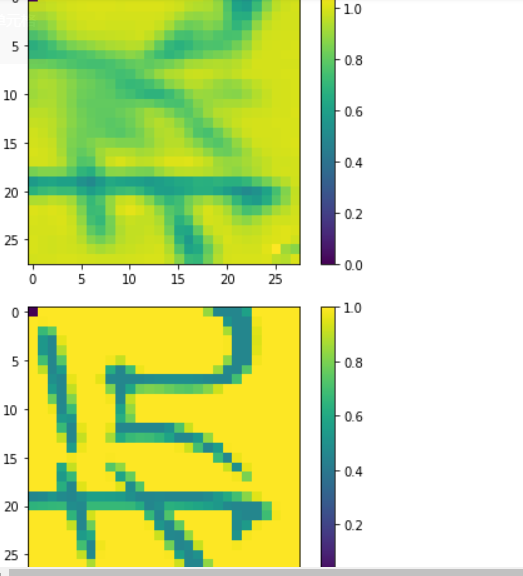

## 实验效果
1. 这种图就会出现偏旁错误的情况。偏旁错误会严重影响汉字，所以可能把感知域再收缩变成5x5 或者模型加深 可能会好点儿
2. 可能是merge出现问题，不能简单地merge，保留最可信的部分。

In [ ]:
import time
from skimage.metrics import peak_signal_noise_ratio,structural_similarity, mean_squared_error

for it in range(0,3):
  print('-------------------',it)
  psnr = 0
  for t in range(1):
    data,ans = next(test_pic_generators[it])
    
    import matplotlib
    cmap = matplotlib.cm.gray 
    cmap.set_bad(color='black')

    t=time.time()
    
    print("four input images(bgr):")
    for i in range(4):
      plt.subplot(221+i)
      plt.imshow(data[i])
      #b,g,r = cv2.split(data[i])       # get b,g,r
      #rgb_img = cv2.merge([r,g,b])     # switch it to rgb
      #plt.imshow(rgb_img)
      #cv2.imwrite('/content/drive/My Drive/data'+str(i)+'.jpg',data[i])
    plt.show()
    print("answer:")
    plt.imshow(ans)
    plt.show()


    
    
      # xpic: array of 5 with size(22,52,1)
    picsizex = data[0].shape[0]
    picsizey = data[0].shape[1]
    datasizex = dat_size_x
    datasizey = dat_size_y
    picout = np.zeros((picsizex*enhance,picsizey*enhance,datasizex*datasizey),dtype=np.float32)
    piclayer = np.zeros((picsizex*enhance,picsizey*enhance),dtype=int)
    for posx in range(0,picsizex-datasizex,10):#debug-------------------------------------------------------------------------------step    
      for posy in range(0,picsizey-datasizey,10):#84-15+1-datasizey):
    #for posx in range(0,picsizex+1-datasizex):      
    #  for posy in range(0,picsizey+1-datasizey):
        dataout = [pic[np.newaxis,posx:posx+datasizex,posy:posy+datasizey,:] for pic in data]
        
        pred = model_a.predict(dataout)
        for px in range(datasizex*enhance):
          for py in range(datasizey*enhance):
            picout[posx*enhance+px,posy*enhance+py,piclayer[posx*enhance+px,posy*enhance+py]] = pred[0,px,py,0]
            piclayer[posx*enhance+px,posy*enhance+py]+=1      
      
    #picout2 = np.zeros((picsizex*enhance,picsizey*enhance)）
    mina = np.percentile(picout, 20, axis=2)
    maxa = np.percentile(picout, 80, axis=2)
    for posx in range(0,picsizex):
      for posy in range(0,picsizey):                     
        for j in range(piclayer[posx,posy]):
          if(picout[posx,posy,j]>maxa[posx,posy] or picout[posx,posy,j]<mina[posx,posy]):
            if(piclayer[posx,posy]>1):
              picout[posx,posy,j]=0
              piclayer[posx,posy]-=1
            else:
              picout[posx,posy,j]=1
    picout2 = np.sum(picout,axis=2)
    picout2 /= piclayer
    picout2[np.isnan(picout2)] = 1

        
    ans[0,0]=1
    
    pred = pred[0,:,:,0]
    #plt.subplot(121)
    plt.imshow(picout2,cmap=cmap)
    cv2.imwrite('/content/drive/My Drive/pred.jpg',picout2)
    plt.show()
    #plt.colorbar()
    #ans = np.clip((ans-np.percentile(ans,10))/(np.percentile(ans,90)-np.percentile(ans,10)),0,1)
    #plt.subplot(122)
    plt.imshow(ans,cmap=cmap)
    #cv2.imwrite('/content/drive/My Drive/ans.jpg',ans)
    plt.show()
    print(picout2.shape,ans.shape)
    print(np.max(picout2),np.max(ans))
    
    print('psnr',psnr)
    #plt.colorbar()
    
    #      print('psnr',peak_signal_noise_ratio(np.clip(pred[0,:,:,0],0,1),ans))
    #      print('ssim',structural_similarity(np.clip(pred[0,:,:,0],0,1),ans))
    #print('mse',mean_squared_error(np.clip(pred,0,1),ans))
